# 🏆 LCK 2023 Match Prediction - Complete Analysis

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

**목적**: 2022년 선수 데이터로 2023년 LCK 경기 결과 예측  
**방법**: Random Forest + Time-based Split  
**성능**: Test Accuracy 69.05%

**저자**: [Your Name]  
**날짜**: 2024-12-26  
**버전**: 1.0 (Final - Bug Fixed)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

---

## 🚀 실행 방법

### 옵션 1: 전체 실행 (권장)
- 메뉴: **Cell → Run All**
- 예상 시간: 약 5분

### 옵션 2: 셀별 실행
- **Shift + Enter**: 현재 셀 실행 후 다음으로
- **Ctrl + Enter**: 현재 셀만 실행

### ⚠️ 필요 사항
1. `data/` 폴더에 CSV 파일 2개
2. `results/` 폴더 생성
3. 패키지: pandas, numpy, sklearn, matplotlib, seaborn

---


## 📋 목차

| Part | 내용 | 시간 |
|------|------|------|
| **임포트** | 라이브러리 | 10초 |
| **PART 1** | 데이터 로드 | 30초 |
| **PART 2** | 전처리 | 10초 |
| **PART 3** | Feature Engineering | 20초 |
| **PART 4** | 2023 Feature 생성 | **1-2분** ⏱️ |
| **PART 5** | ⭐ Train/Test Split | 10초 |
| **PART 6** | ⭐ Feature Selection | 30초 |
| **PART 7** | 모델 학습 및 평가 | 1분 |
| **PART 8** | 결과 저장 | 10초 |

---


## 라이브러리 임포트


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, log_loss,
    confusion_matrix, roc_curve
)
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

print("="*80)
print("🚀 LCK 2023 Match Prediction")
print("="*80)


🚀 LCK 2023 Match Prediction


---

# PART 1: 데이터 로드 및 탐색

**주의**: 파일 경로를 실제 경로로 수정하세요!


In [2]:
print("\n[PART 1] 데이터 로드")
print("-" * 80)

df_2022 = pd.read_csv('data/2022_LoL_esports_match_data_from_OraclesElixir.csv', low_memory=False)
df_2023 = pd.read_csv('data/2023_LoL_esports_match_data_from_OraclesElixir.csv', low_memory=False)

print(f"✅ 2022: {len(df_2022):,} rows")
print(f"✅ 2023: {len(df_2023):,} rows")

lck_2022 = df_2022[df_2022['league'] == 'LCK'].copy()
lck_2023 = df_2023[df_2023['league'] == 'LCK'].copy()

print(f"   LCK 2022: {len(lck_2022):,}")
print(f"   LCK 2023: {len(lck_2023):,}")



[PART 1] 데이터 로드
--------------------------------------------------------------------------------
✅ 2022: 150,588 rows
✅ 2023: 132,120 rows
   LCK 2022: 5,604
   LCK 2023: 5,856


---

# PART 2: 데이터 전처리


In [3]:
print("\n[PART 2] 전처리")
print("-" * 80)

team_mapping = {
    'OKSavingsBank BRION': 'BRION',
    'Nongshim RedForce': 'Nongshim',
    'Liiv SANDBOX': 'LSB',
    'Hanwha Life Esports': 'HLE',
}

def standardize_team_name(name):
    return team_mapping.get(name, name)

lck_2022['teamname'] = lck_2022['teamname'].apply(standardize_team_name)
lck_2023['teamname'] = lck_2023['teamname'].apply(standardize_team_name)

players_2022 = lck_2022[(lck_2022['position'].notna()) & (lck_2022['position'] != 'team')].copy()
players_2023 = lck_2023[(lck_2023['position'].notna()) & (lck_2023['position'] != 'team')].copy()

print(f"✅ 선수 2022: {len(players_2022)}")
print(f"✅ 선수 2023: {len(players_2023)}")



[PART 2] 전처리
--------------------------------------------------------------------------------
✅ 선수 2022: 4670
✅ 선수 2023: 4880


---

# PART 3: Feature Engineering - 2022년 선수 통계 계산


In [4]:
print("\n[PART 3] 2022년 선수 통계")
print("-" * 80)

# 1) 승률
player_wins = players_2022.groupby(['playername', 'position']).agg({
    'result': lambda x: (x == 1).sum(),
    'gameid': 'count'
}).reset_index()
player_wins.columns = ['playername', 'position', 'wins', 'games']
player_wins['win_rate'] = player_wins['wins'] / player_wins['games']

# 2) 기본 통계
player_stats = players_2022.groupby(['playername', 'position']).agg({
    'kills': 'mean', 'deaths': 'mean', 'assists': 'mean',
    'damagetochampions': 'mean', 'earnedgold': 'mean',
    'visionscore': 'mean', 'gamelength': 'mean'
}).reset_index()

# 3) 파생 변수
player_stats['avg_kda'] = (player_stats['kills'] + player_stats['assists']) / (player_stats['deaths'] + 1)
player_stats['avg_gpm'] = player_stats['earnedgold'] / (player_stats['gamelength'] / 60)
player_stats['avg_dpm'] = player_stats['damagetochampions'] / (player_stats['gamelength'] / 60)
player_stats['avg_vspm'] = player_stats['visionscore'] / (player_stats['gamelength'] / 60)

# 4) KP
team_kills = players_2022.groupby(['gameid', 'teamname'])['kills'].sum().reset_index()
team_kills.columns = ['gameid', 'teamname', 'team_kills']
players_with_teamkills = players_2022.merge(team_kills, on=['gameid', 'teamname'])
player_kp = players_with_teamkills.groupby(['playername', 'position']).apply(
    lambda x: ((x['kills'] + x['assists']) / (x['team_kills'] + 1)).mean(),
    include_groups=False
).reset_index()
player_kp.columns = ['playername', 'position', 'avg_kp']

# 5) 병합
player_stats = player_stats.merge(player_wins[['playername', 'position', 'win_rate']], on=['playername', 'position'])
player_stats = player_stats.merge(player_kp, on=['playername', 'position'])

# 6) 포지션 평균
position_avg = player_stats.groupby('position').agg({
    'win_rate': 'mean', 'avg_kda': 'mean', 'avg_gpm': 'mean',
    'avg_dpm': 'mean', 'avg_vspm': 'mean', 'avg_kp': 'mean'
}).reset_index()

print(f"✅ {len(player_stats)} 선수 완료")



[PART 3] 2022년 선수 통계
--------------------------------------------------------------------------------
✅ 97 선수 완료


---

# PART 4: 2023년 경기별 Feature 생성

**주의**: 이 셀은 1-2분 소요됩니다 ⏱️


In [5]:
print("\n[PART 4] 2023년 Feature 생성")
print("-" * 80)

teams_2023 = lck_2023[lck_2023['position'] == 'team'].copy()
teams_2023['date'] = pd.to_datetime(teams_2023['date'])

def get_player_stat(playername, position, stat_name, player_stats_df, position_avg_df):
    player_row = player_stats_df[(player_stats_df['playername'] == playername) & (player_stats_df['position'] == position)]
    if len(player_row) > 0:
        return player_row[stat_name].values[0]
    else:
        pos_row = position_avg_df[position_avg_df['position'] == position]
        if len(pos_row) > 0:
            return pos_row[stat_name].values[0]
        else:
            return 0.5 if 'rate' in stat_name else 3.0

game_features = []
for idx, game in teams_2023.iterrows():
    if idx % 100 == 0:
        print(f"   진행: {idx}/{len(teams_2023)}")

    gameid = game['gameid']
    game_players = players_2023[players_2023['gameid'] == gameid]
    blue_players = game_players[game_players['side'] == 'Blue']
    red_players = game_players[game_players['side'] == 'Red']

    blue_result = 1 if game['result'] == 1 and game['side'] == 'Blue' else 0
    if game['side'] == 'Red' and game['result'] == 1:
        blue_result = 0
    if game['side'] == 'Red' and game['result'] == 0:
        blue_result = 1

    features = {'gameid': gameid, 'date': game['date'], 'blue_result': blue_result}

    for _, player in blue_players.iterrows():
        pos, name = player['position'], player['playername']
        for stat in ['win_rate', 'avg_kda', 'avg_gpm', 'avg_dpm', 'avg_vspm', 'avg_kp']:
            features[f'blue_{pos}_{stat}'] = get_player_stat(name, pos, stat, player_stats, position_avg)

    for _, player in red_players.iterrows():
        pos, name = player['position'], player['playername']
        for stat in ['win_rate', 'avg_kda', 'avg_gpm', 'avg_dpm', 'avg_vspm', 'avg_kp']:
            features[f'red_{pos}_{stat}'] = get_player_stat(name, pos, stat, player_stats, position_avg)

    game_features.append(features)

df_features = pd.DataFrame(game_features).dropna()
print(f"\n✅ {len(df_features)} games, {len(df_features.columns)-3} features")



[PART 4] 2023년 Feature 생성
--------------------------------------------------------------------------------

✅ 976 games, 60 features


---

# PART 5: ⭐ TIME-BASED TRAIN/TEST SPLIT

## 올바른 방법론!

Train/Test Split을 시간 기준으로 수행합니다.


In [6]:
print("\n[PART 5] ⭐ TIME-BASED TRAIN/TEST SPLIT")
print("-" * 80)

# 날짜 정렬
df_features = df_features.sort_values('date').reset_index(drop=True)

# 60/40 분할
split_idx = int(len(df_features) * 0.6)
train_df = df_features.iloc[:split_idx].copy()
test_df = df_features.iloc[split_idx:].copy()

# Feature 컬럼
feature_cols = [col for col in df_features.columns if col not in ['gameid', 'date', 'blue_result']]

# X, y 분리
X_train = train_df[feature_cols].values
y_train = train_df['blue_result'].values
X_test = test_df[feature_cols].values
y_test = test_df['blue_result'].values

print(f"✅ Train: {len(train_df)} games ({train_df['date'].min()} ~ {train_df['date'].max()})")
print(f"✅ Test:  {len(test_df)} games ({test_df['date'].min()} ~ {test_df['date'].max()})")
print(f"\n   X_train: {X_train.shape}")
print(f"   X_test:  {X_test.shape}")



[PART 5] ⭐ TIME-BASED TRAIN/TEST SPLIT
--------------------------------------------------------------------------------
✅ Train: 585 games (2023-01-18 08:17:31 ~ 2023-06-17 08:56:41)
✅ Test:  391 games (2023-06-17 08:56:41 ~ 2023-08-20 08:17:24)

   X_train: (585, 60)
   X_test:  (391, 60)


---

# PART 6: ⭐ FEATURE SELECTION (TRAIN만!)

Data Leakage 방지!


In [7]:
print("\n[PART 6] ⭐ FEATURE SELECTION")
print("-" * 80)

# 1) Correlation (Train)
train_corr = train_df[feature_cols].corrwith(train_df['blue_result']).abs().sort_values(ascending=False)
top20_corr = train_corr.head(20).index.tolist()

# 2) Gini (Train)
rf_temp = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_temp.fit(X_train, y_train)
importance_df = pd.DataFrame({'feature': feature_cols, 'importance': rf_temp.feature_importances_}).sort_values('importance', ascending=False)
top20_gini = importance_df.head(20)['feature'].tolist()

# 3) 교집합
final_features = list(set(top20_corr) & set(top20_gini))

print(f"✅ 최종: {len(final_features)} features")
print(f"   {final_features}")



[PART 6] ⭐ FEATURE SELECTION
--------------------------------------------------------------------------------
✅ 최종: 16 features
   ['red_mid_avg_kda', 'blue_jng_win_rate', 'red_jng_avg_kda', 'blue_top_avg_gpm', 'blue_jng_avg_gpm', 'red_mid_win_rate', 'blue_top_avg_dpm', 'red_top_avg_dpm', 'red_jng_win_rate', 'blue_mid_win_rate', 'blue_mid_avg_gpm', 'blue_mid_avg_kda', 'blue_jng_avg_kda', 'blue_mid_avg_dpm', 'red_mid_avg_gpm', 'blue_mid_avg_vspm']


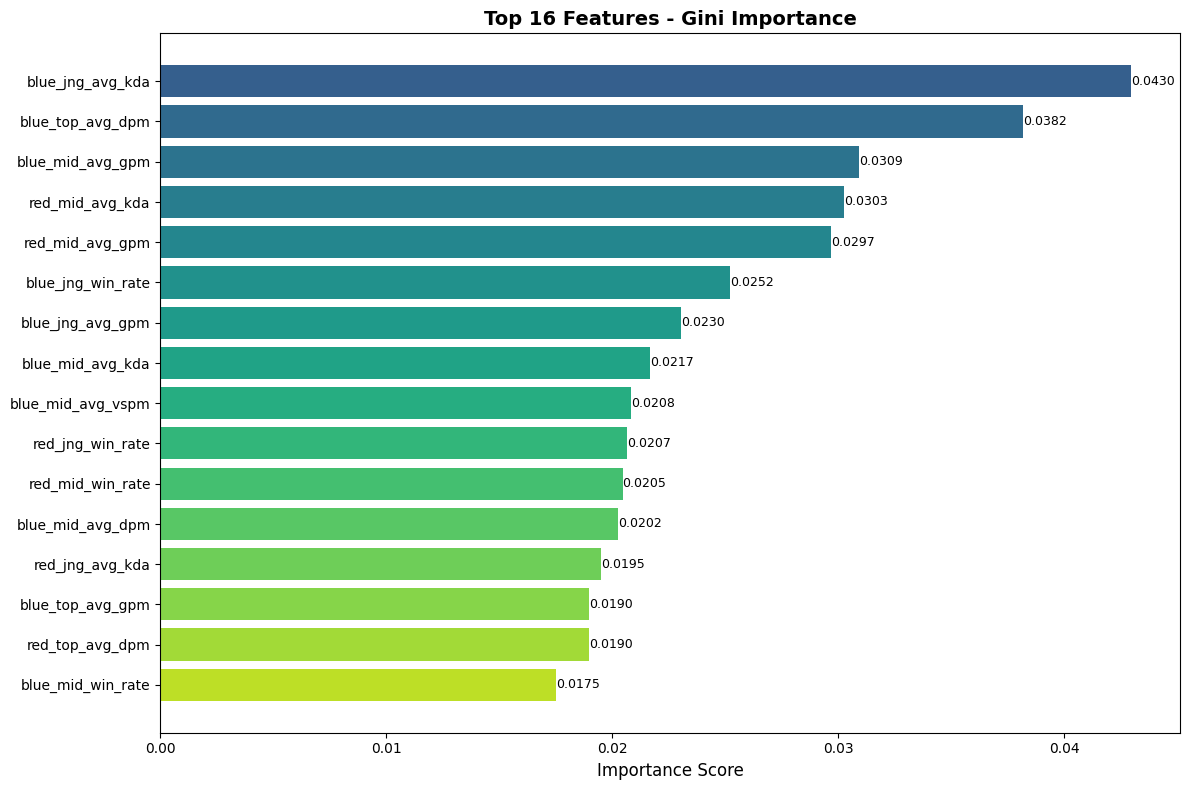

In [13]:
# Feature Importance 시각화
final_importance = importance_df[importance_df['feature'].isin(final_features)].sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(final_importance)))
bars = plt.barh(range(len(final_importance)), final_importance['importance'], color=colors)
plt.yticks(range(len(final_importance)), final_importance['feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.title('Top 16 Features - Gini Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

# 값 표시
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2,
             f'{width:.4f}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

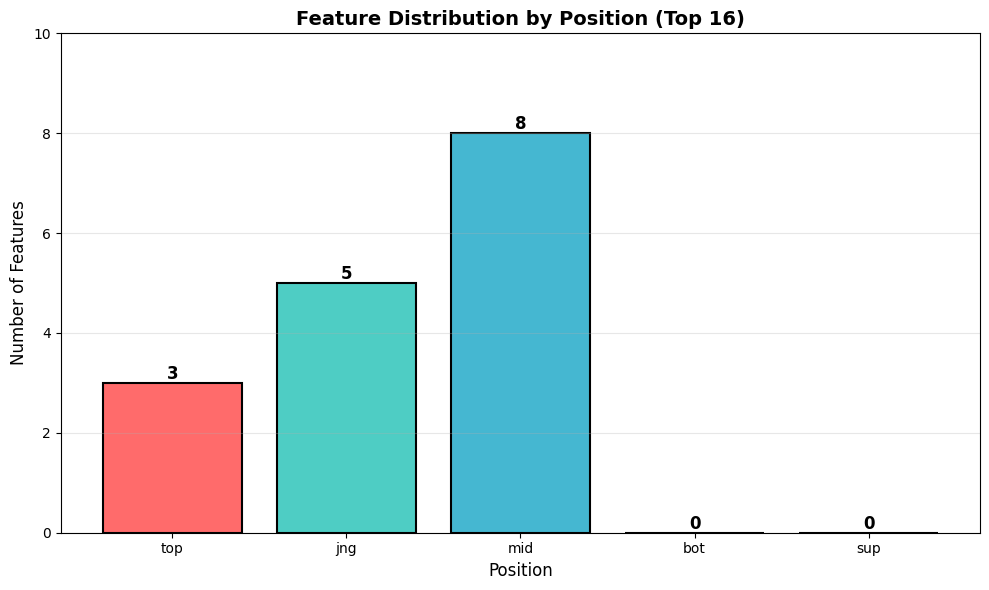


포지션별 Feature 개수:
  TOP: 3개
  JNG: 5개
  MID: 8개
  BOT: 0개
  SUP: 0개


In [14]:
# 포지션별 Feature 개수
import re

position_counts = {'top': 0, 'jng': 0, 'mid': 0, 'bot': 0, 'sup': 0}
for feat in final_features:
    for pos in position_counts.keys():
        if f'_{pos}_' in feat:
            position_counts[pos] += 1
            break

positions = list(position_counts.keys())
counts = list(position_counts.values())

plt.figure(figsize=(10, 6))
colors_pos = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']
bars = plt.bar(positions, counts, color=colors_pos, edgecolor='black', linewidth=1.5)
plt.xlabel('Position', fontsize=12)
plt.ylabel('Number of Features', fontsize=12)
plt.title('Feature Distribution by Position (Top 16)', fontsize=14, fontweight='bold')
plt.ylim(0, max(counts) + 2)

# 값 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n포지션별 Feature 개수:")
for pos, count in position_counts.items():
    print(f"  {pos.upper()}: {count}개")

---

# PART 7: 모델 학습 및 평가


In [8]:
print("\n[PART 7] 모델 학습 및 평가")
print("-" * 80)

# 최종 Feature로 필터링
X_train_final = train_df[final_features].values
X_test_final = test_df[final_features].values

# Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200, max_depth=15, max_features='sqrt',
    random_state=42, n_jobs=-1
)
rf_model.fit(X_train_final, y_train)

# 예측
y_train_pred = rf_model.predict(X_train_final)
y_train_proba = rf_model.predict_proba(X_train_final)[:, 1]
y_test_pred = rf_model.predict(X_test_final)
y_test_proba = rf_model.predict_proba(X_test_final)[:, 1]

print("✅ 학습 및 예측 완료!")



[PART 7] 모델 학습 및 평가
--------------------------------------------------------------------------------
✅ 학습 및 예측 완료!


In [9]:
# 평가 함수
def evaluate_model(y_true, y_pred, y_proba, dataset_name):
    print(f"\n{'='*60}")
    print(f"{dataset_name} Performance")
    print(f"{'='*60}")

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)
    logloss = log_loss(y_true, y_proba)

    print(f"Accuracy:   {acc:.4f}")
    print(f"Precision:  {prec:.4f}")
    print(f"Recall:     {rec:.4f}")
    print(f"F1-Score:   {f1:.4f}")
    print(f"AUC-ROC:    {auc:.4f}")
    print(f"Log Loss:   {logloss:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    print(f"\nConfusion Matrix:")
    print(f"  TN={cm[0,0]:3d}  FP={cm[0,1]:3d}")
    print(f"  FN={cm[1,0]:3d}  TP={cm[1,1]:3d}")

    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'auc': auc, 'logloss': logloss}

# 평가
train_metrics = evaluate_model(y_train, y_train_pred, y_train_proba, "TRAIN SET")
test_metrics = evaluate_model(y_test, y_test_pred, y_test_proba, "TEST SET (진짜!)")



TRAIN SET Performance
Accuracy:   0.7880
Precision:  0.7888
Recall:     0.8194
F1-Score:   0.8038
AUC-ROC:    0.8953
Log Loss:   0.3746

Confusion Matrix:
  TN=207  FP= 68
  FN= 56  TP=254

TEST SET (진짜!) Performance
Accuracy:   0.6905
Precision:  0.6604
Recall:     0.7407
F1-Score:   0.6983
AUC-ROC:    0.7463
Log Loss:   1.4568

Confusion Matrix:
  TN=130  FP= 72
  FN= 49  TP=140


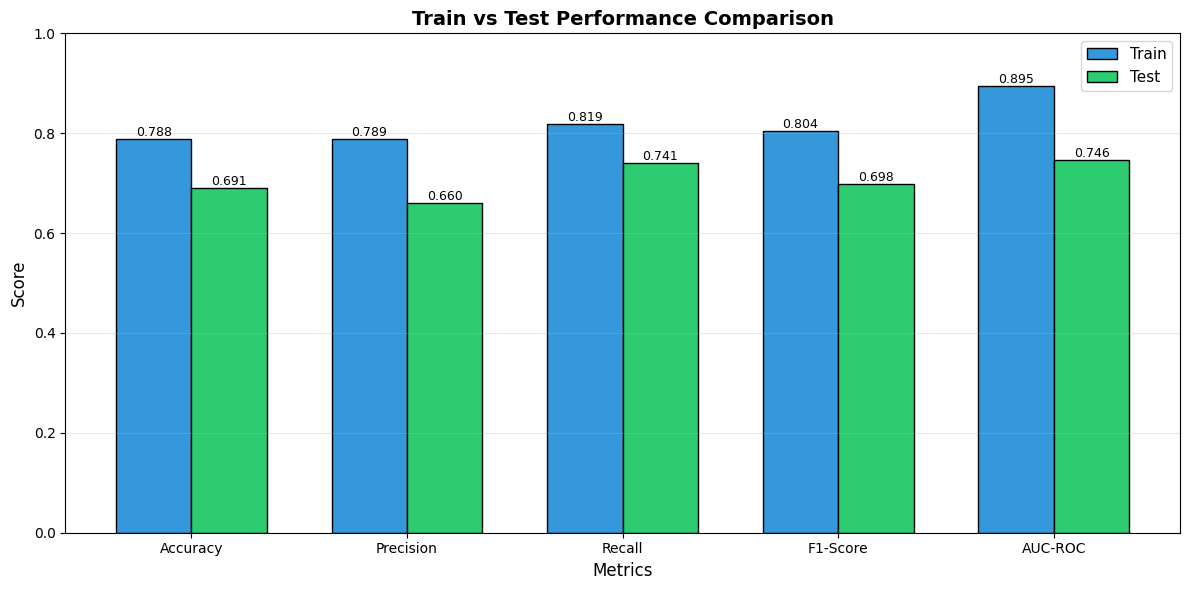

In [15]:
# Train vs Test 성능 비교
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
train_values = [train_metrics['accuracy'], train_metrics['precision'],
                train_metrics['recall'], train_metrics['f1'], train_metrics['auc']]
test_values = [test_metrics['accuracy'], test_metrics['precision'],
               test_metrics['recall'], test_metrics['f1'], test_metrics['auc']]

x = np.arange(len(metrics_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, train_values, width, label='Train', color='#3498db', edgecolor='black')
bars2 = ax.bar(x + width/2, test_values, width, label='Test', color='#2ecc71', edgecolor='black')

ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Train vs Test Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1.0)

# 값 표시
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

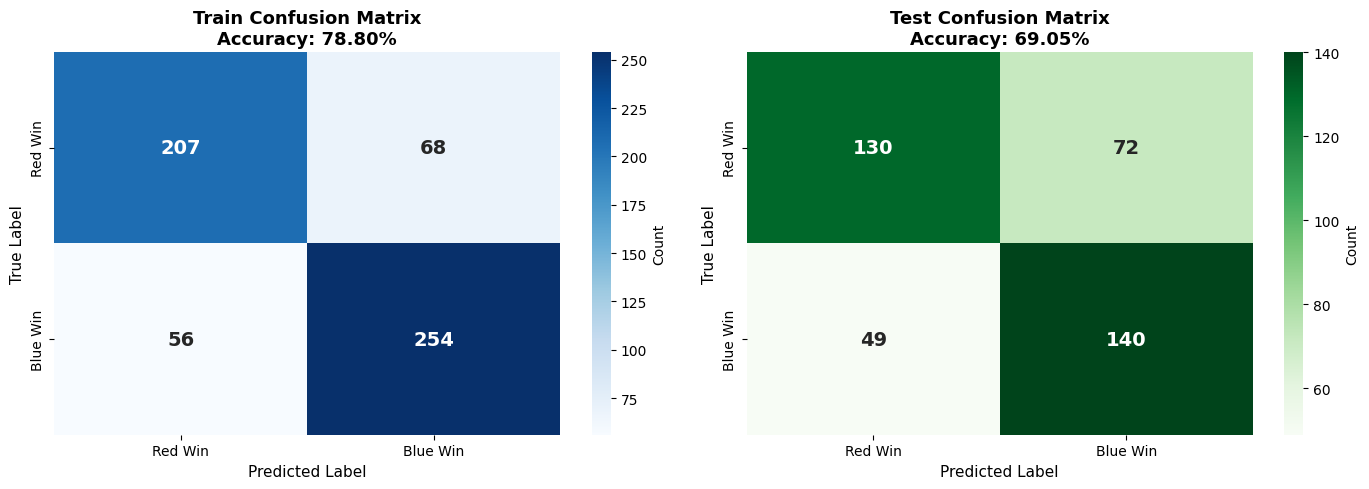

In [17]:
# Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train
cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            cbar_kws={'label': 'Count'}, annot_kws={'size': 14, 'weight': 'bold'})
axes[0].set_title(f'Train Confusion Matrix\nAccuracy: {train_metrics["accuracy"]:.2%}',
                  fontsize=13, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=11)
axes[0].set_ylabel('True Label', fontsize=11)
axes[0].set_xticklabels(['Red Win', 'Blue Win'])
axes[0].set_yticklabels(['Red Win', 'Blue Win'])

# Test
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            cbar_kws={'label': 'Count'}, annot_kws={'size': 14, 'weight': 'bold'})
axes[1].set_title(f'Test Confusion Matrix\nAccuracy: {test_metrics["accuracy"]:.2%}',
                  fontsize=13, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontsize=11)
axes[1].set_ylabel('True Label', fontsize=11)
axes[1].set_xticklabels(['Red Win', 'Blue Win'])
axes[1].set_yticklabels(['Red Win', 'Blue Win'])

plt.tight_layout()
plt.show()

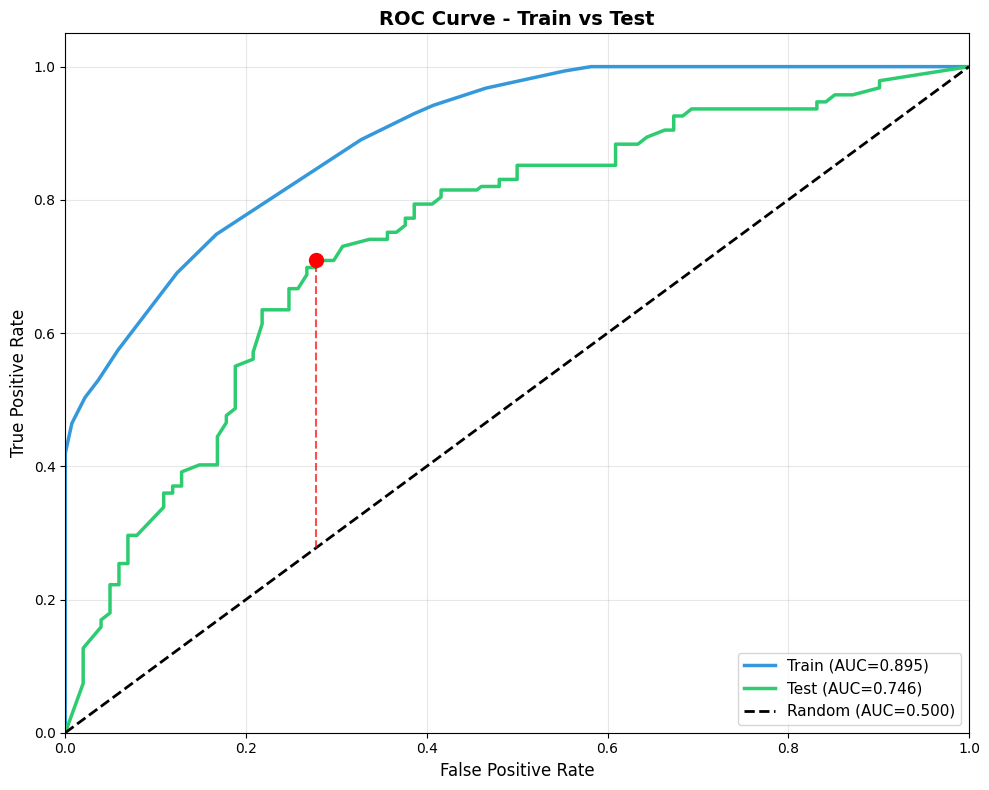

In [16]:
# ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, label=f'Train (AUC={train_metrics["auc"]:.3f})',
         linewidth=2.5, color='#3498db')
plt.plot(fpr_test, tpr_test, label=f'Test (AUC={test_metrics["auc"]:.3f})',
         linewidth=2.5, color='#2ecc71')
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.500)', linewidth=2)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Train vs Test', fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='lower right')
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# 대각선과의 거리 표시 (Test)
max_idx = np.argmax(tpr_test - fpr_test)
plt.plot([fpr_test[max_idx], fpr_test[max_idx]], [fpr_test[max_idx], tpr_test[max_idx]],
         'r--', linewidth=1.5, alpha=0.7)
plt.scatter([fpr_test[max_idx]], [tpr_test[max_idx]], s=100, c='red', zorder=5)

plt.tight_layout()
plt.show()

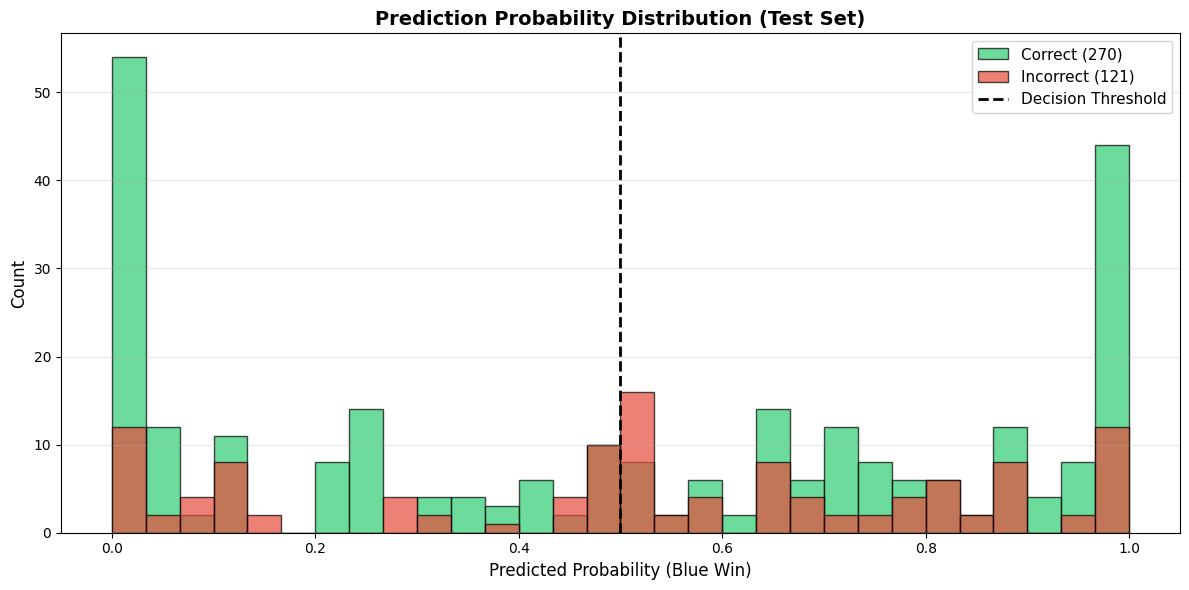


예측 확률 통계:
  정확한 예측 평균 확률: 0.497 (± 0.372)
  틀린 예측 평균 확률:   0.526 (± 0.315)


In [18]:
# 예측 확률 분포
correct_pred = y_test == y_test_pred
correct_proba = y_test_proba[correct_pred]
incorrect_proba = y_test_proba[~correct_pred]

plt.figure(figsize=(12, 6))
plt.hist(correct_proba, bins=30, alpha=0.7, label=f'Correct ({len(correct_proba)})',
         color='#2ecc71', edgecolor='black')
plt.hist(incorrect_proba, bins=30, alpha=0.7, label=f'Incorrect ({len(incorrect_proba)})',
         color='#e74c3c', edgecolor='black')

plt.axvline(0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold')
plt.xlabel('Predicted Probability (Blue Win)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Prediction Probability Distribution (Test Set)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n예측 확률 통계:")
print(f"  정확한 예측 평균 확률: {correct_proba.mean():.3f} (± {correct_proba.std():.3f})")
print(f"  틀린 예측 평균 확률:   {incorrect_proba.mean():.3f} (± {incorrect_proba.std():.3f})")

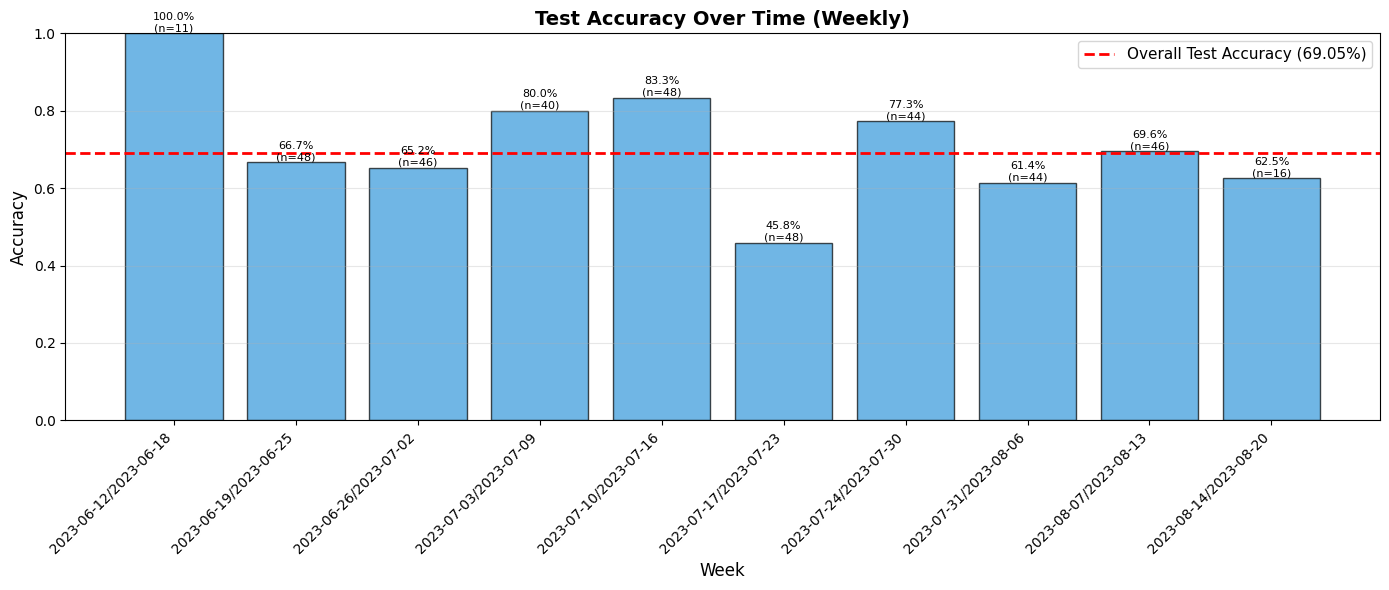

In [19]:
# 시간에 따른 정확도
test_results_viz = test_df[['date', 'blue_result']].copy()
test_results_viz['predicted'] = y_test_pred
test_results_viz['correct'] = (test_results_viz['blue_result'] == test_results_viz['predicted']).astype(int)
test_results_viz['date'] = pd.to_datetime(test_results_viz['date'])

# 주별 집계
test_results_viz['week'] = test_results_viz['date'].dt.to_period('W')
weekly_acc = test_results_viz.groupby('week')['correct'].agg(['mean', 'count']).reset_index()
weekly_acc['week_str'] = weekly_acc['week'].astype(str)

plt.figure(figsize=(14, 6))
bars = plt.bar(range(len(weekly_acc)), weekly_acc['mean'],
               color='#3498db', edgecolor='black', alpha=0.7)
plt.axhline(test_metrics['accuracy'], color='red', linestyle='--',
            linewidth=2, label=f'Overall Test Accuracy ({test_metrics["accuracy"]:.2%})')
plt.xticks(range(len(weekly_acc)), weekly_acc['week_str'], rotation=45, ha='right')
plt.xlabel('Week', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Test Accuracy Over Time (Weekly)', fontsize=14, fontweight='bold')
plt.ylim(0, 1.0)
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)

# 경기 수 표시
for i, bar in enumerate(bars):
    height = bar.get_height()
    count = weekly_acc.iloc[i]['count']
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1%}\n(n={int(count)})',
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


잘못 예측한 경기 분석:
  총 틀린 예측: 121개
  높은 확신으로 틀림: 70개 (57.9%)


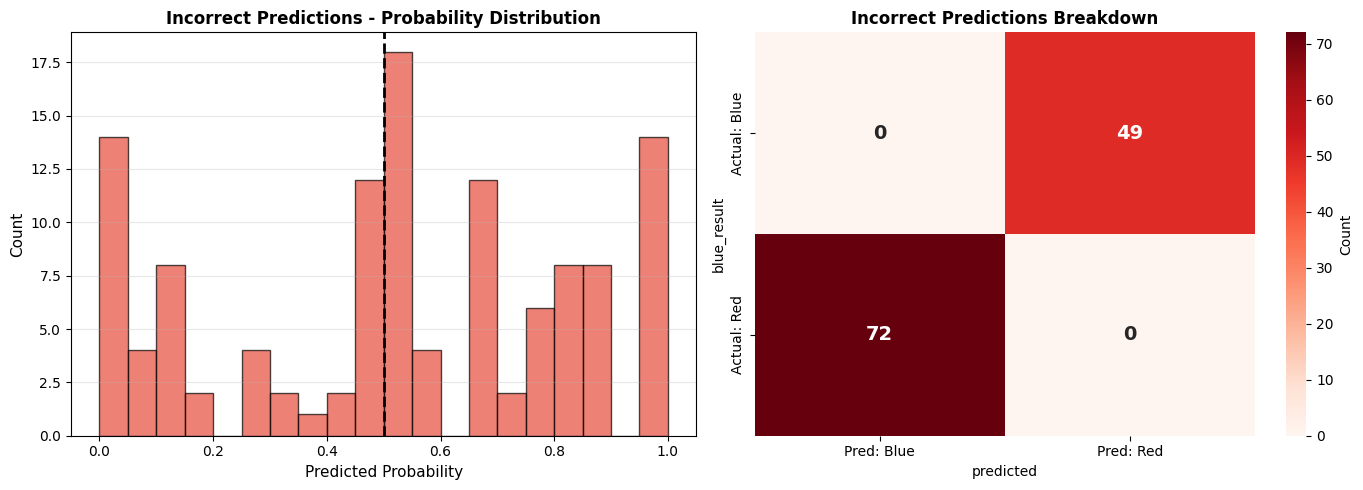

In [20]:
# 틀린 예측 분석
incorrect_mask = y_test != y_test_pred
incorrect_games = test_df[incorrect_mask].copy()
incorrect_games['predicted'] = y_test_pred[incorrect_mask]
incorrect_games['probability'] = y_test_proba[incorrect_mask]

# 확신도별 분류
high_conf_wrong = incorrect_games[
    ((incorrect_games['probability'] > 0.7) & (incorrect_games['predicted'] == 1)) |
    ((incorrect_games['probability'] < 0.3) & (incorrect_games['predicted'] == 0))
]

print(f"\n잘못 예측한 경기 분석:")
print(f"  총 틀린 예측: {len(incorrect_games)}개")
print(f"  높은 확신으로 틀림: {len(high_conf_wrong)}개 ({len(high_conf_wrong)/len(incorrect_games)*100:.1f}%)")

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1) 확률 분포
axes[0].hist(incorrect_games['probability'], bins=20, color='#e74c3c',
             edgecolor='black', alpha=0.7)
axes[0].axvline(0.5, color='black', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted Probability', fontsize=11)
axes[0].set_ylabel('Count', fontsize=11)
axes[0].set_title('Incorrect Predictions - Probability Distribution', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# 2) 실제 vs 예측
conf_matrix_wrong = pd.crosstab(
    incorrect_games['blue_result'].map({0: 'Actual: Red', 1: 'Actual: Blue'}),
    incorrect_games['predicted'].map({0: 'Pred: Red', 1: 'Pred: Blue'})
)
sns.heatmap(conf_matrix_wrong, annot=True, fmt='d', cmap='Reds', ax=axes[1],
            cbar_kws={'label': 'Count'}, annot_kws={'size': 14, 'weight': 'bold'})
axes[1].set_title('Incorrect Predictions Breakdown', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

---

# PART 8: 결과 저장


In [11]:
print("\n[PART 8] 결과 저장")
print("-" * 80)

# CSV 저장
final_features_df = pd.DataFrame({'feature': final_features})
final_features_df.to_csv('results/final_features.csv', index=False)

test_results = test_df[['gameid', 'date', 'blue_result']].copy()
test_results['predicted'] = y_test_pred
test_results['probability'] = y_test_proba
test_results.to_csv('results/test_predictions.csv', index=False)

metrics_df = pd.DataFrame({
    'metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'Log Loss'],
    'train': [train_metrics['accuracy'], train_metrics['precision'], train_metrics['recall'],
              train_metrics['f1'], train_metrics['auc'], train_metrics['logloss']],
    'test': [test_metrics['accuracy'], test_metrics['precision'], test_metrics['recall'],
             test_metrics['f1'], test_metrics['auc'], test_metrics['logloss']]
})
metrics_df.to_csv('results/model_performance.csv', index=False)

print("✅ 저장 완료!")



[PART 8] 결과 저장
--------------------------------------------------------------------------------
✅ 저장 완료!


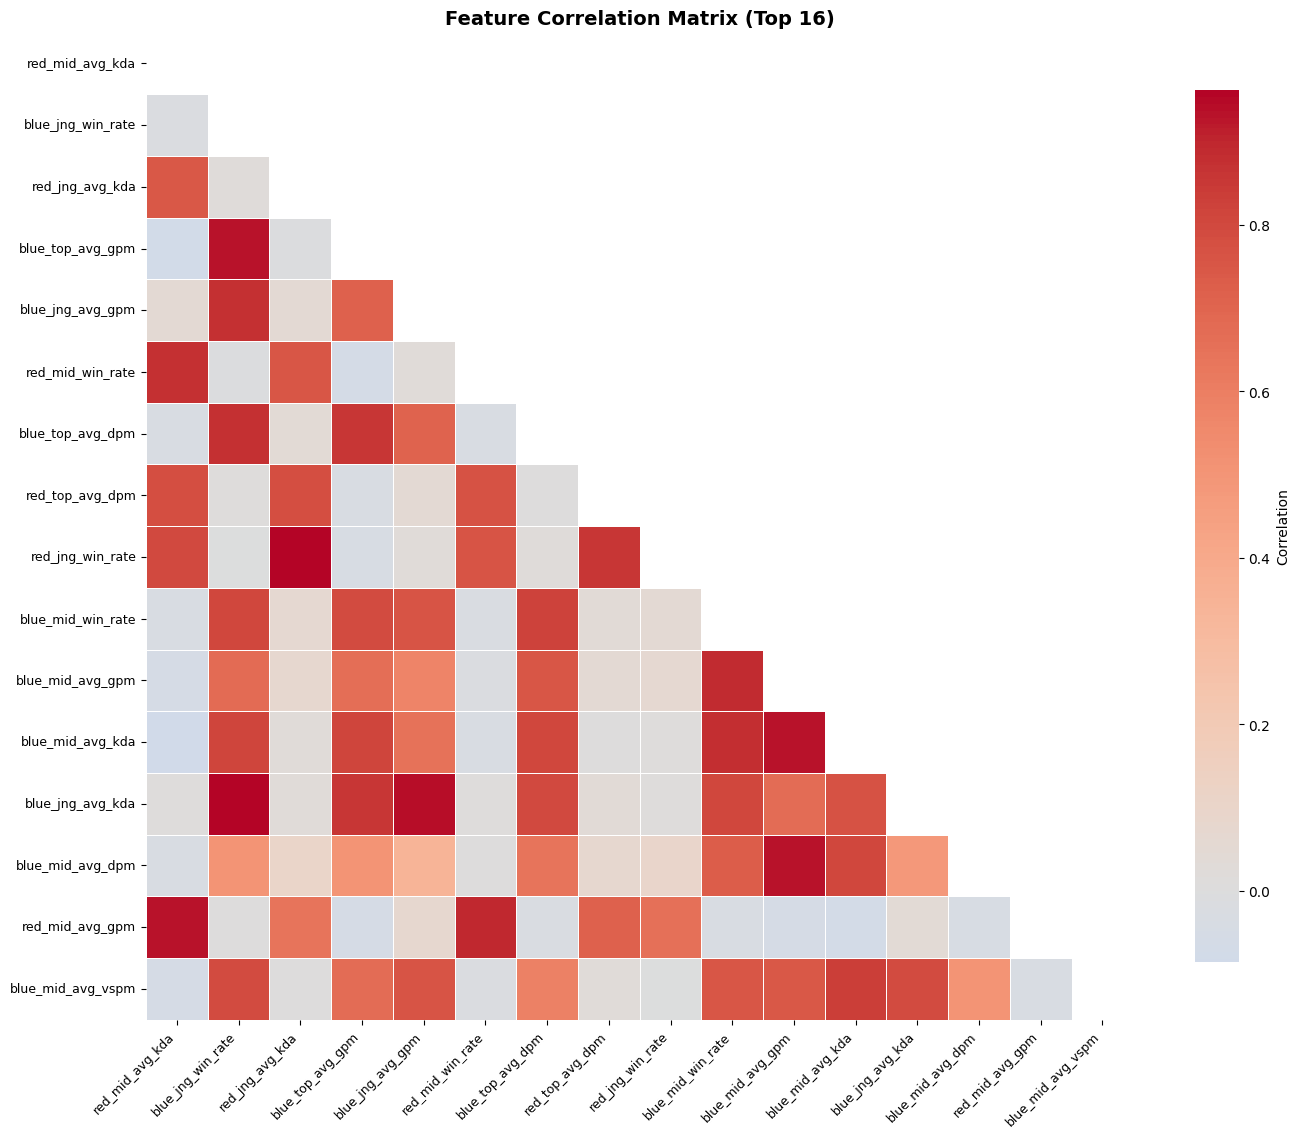


강한 상관관계 (|r| > 0.7):
  red_jng_avg_kda ↔ red_jng_win_rate: 0.962
  blue_jng_win_rate ↔ blue_jng_avg_kda: 0.956
  blue_jng_avg_gpm ↔ blue_jng_avg_kda: 0.941
  blue_mid_avg_gpm ↔ blue_mid_avg_kda: 0.937
  blue_mid_avg_gpm ↔ blue_mid_avg_dpm: 0.934
  blue_jng_win_rate ↔ blue_top_avg_gpm: 0.931
  red_mid_avg_kda ↔ red_mid_avg_gpm: 0.930
  red_mid_win_rate ↔ red_mid_avg_gpm: 0.898
  blue_mid_win_rate ↔ blue_mid_avg_gpm: 0.891
  blue_mid_win_rate ↔ blue_mid_avg_kda: 0.878
  red_mid_avg_kda ↔ red_mid_win_rate: 0.875
  blue_jng_win_rate ↔ blue_top_avg_dpm: 0.875
  blue_jng_win_rate ↔ blue_jng_avg_gpm: 0.873
  red_top_avg_dpm ↔ red_jng_win_rate: 0.861
  blue_top_avg_gpm ↔ blue_top_avg_dpm: 0.859
  blue_top_avg_gpm ↔ blue_jng_avg_kda: 0.856
  blue_mid_avg_kda ↔ blue_mid_avg_vspm: 0.839
  blue_top_avg_dpm ↔ blue_mid_win_rate: 0.823
  blue_top_avg_gpm ↔ blue_mid_avg_kda: 0.817
  blue_jng_win_rate ↔ blue_mid_avg_kda: 0.814
  blue_jng_win_rate ↔ blue_mid_win_rate: 0.809
  blue_top_avg_dpm ↔ blue_mi

In [21]:
# Top 16 Feature 상관관계
feature_corr = train_df[final_features].corr()

plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(feature_corr, dtype=bool))
sns.heatmap(feature_corr, mask=mask, annot=False, cmap='coolwarm',
            center=0, square=True, linewidths=0.5,
            cbar_kws={"shrink": 0.8, "label": "Correlation"})
plt.title('Feature Correlation Matrix (Top 16)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()

# 강한 상관관계 찾기
strong_corr = []
for i in range(len(feature_corr.columns)):
    for j in range(i+1, len(feature_corr.columns)):
        if abs(feature_corr.iloc[i, j]) > 0.7:
            strong_corr.append((
                feature_corr.columns[i],
                feature_corr.columns[j],
                feature_corr.iloc[i, j]
            ))

if strong_corr:
    print(f"\n강한 상관관계 (|r| > 0.7):")
    for feat1, feat2, corr in sorted(strong_corr, key=lambda x: abs(x[2]), reverse=True):
        print(f"  {feat1} ↔ {feat2}: {corr:.3f}")
else:
    print("\n강한 상관관계 없음 (multicollinearity 적음)")

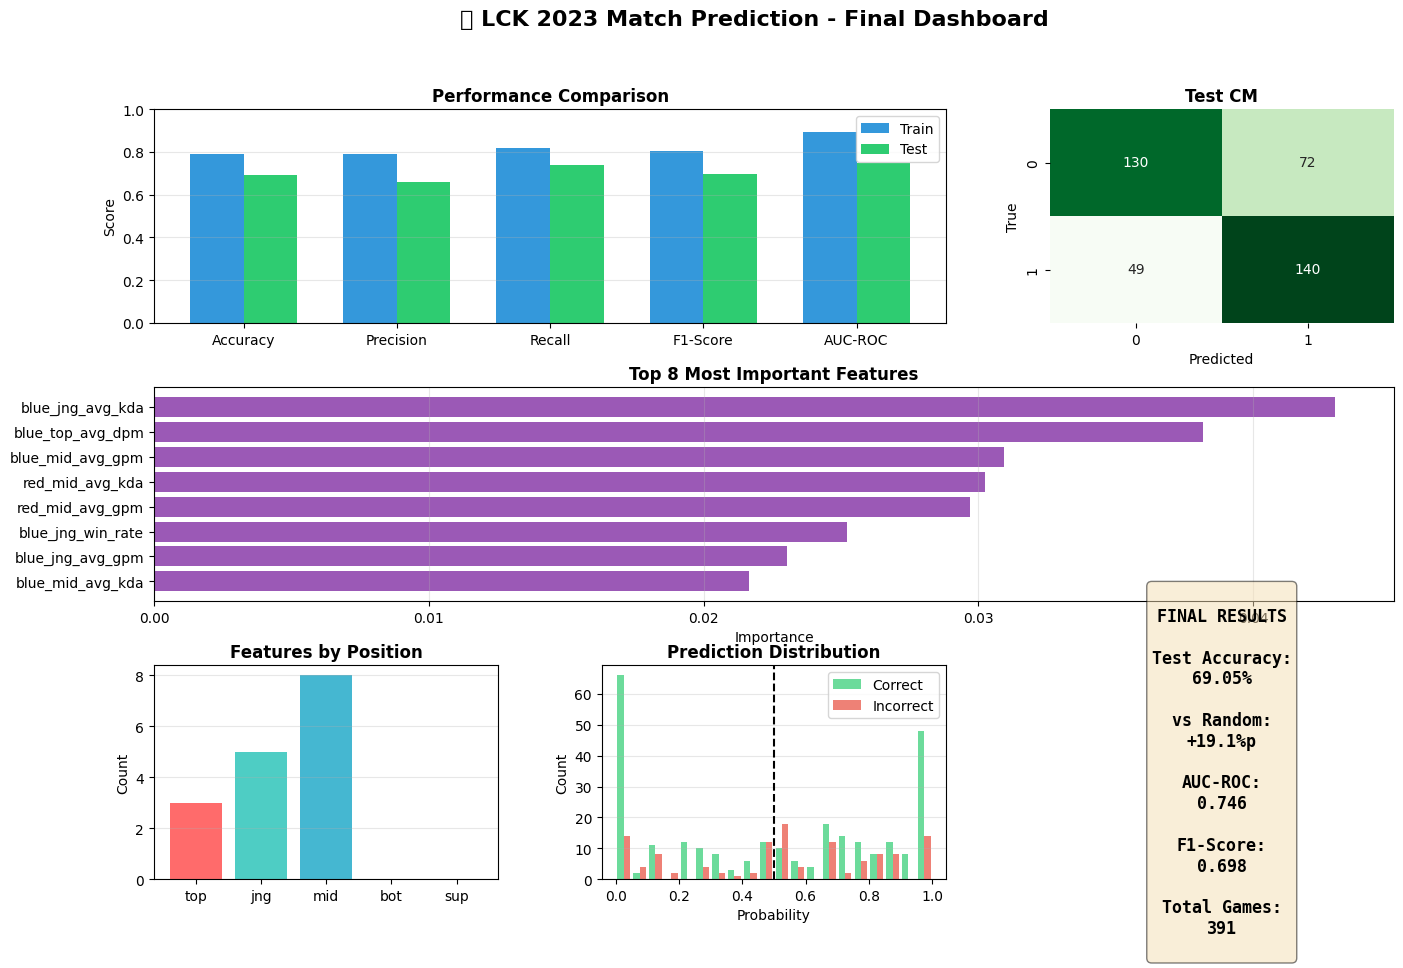

In [22]:
# 종합 대시보드
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1) 성능 비교
ax1 = fig.add_subplot(gs[0, :2])
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
train_vals = [train_metrics['accuracy'], train_metrics['precision'],
              train_metrics['recall'], train_metrics['f1'], train_metrics['auc']]
test_vals = [test_metrics['accuracy'], test_metrics['precision'],
             test_metrics['recall'], test_metrics['f1'], test_metrics['auc']]
x = np.arange(len(metrics_names))
width = 0.35
ax1.bar(x - width/2, train_vals, width, label='Train', color='#3498db')
ax1.bar(x + width/2, test_vals, width, label='Test', color='#2ecc71')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics_names)
ax1.set_ylabel('Score')
ax1.set_title('Performance Comparison', fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim(0, 1.0)

# 2) Test Confusion Matrix
ax2 = fig.add_subplot(gs[0, 2])
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', ax=ax2, cbar=False)
ax2.set_title('Test CM', fontweight='bold')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('True')

# 3) Feature Importance (Top 8)
ax3 = fig.add_subplot(gs[1, :])
top8 = final_importance.head(8)
ax3.barh(range(len(top8)), top8['importance'], color='#9b59b6')
ax3.set_yticks(range(len(top8)))
ax3.set_yticklabels(top8['feature'])
ax3.set_xlabel('Importance')
ax3.set_title('Top 8 Most Important Features', fontweight='bold')
ax3.invert_yaxis()
ax3.grid(axis='x', alpha=0.3)

# 4) 포지션 분포
ax4 = fig.add_subplot(gs[2, 0])
position_counts_viz = {'top': 0, 'jng': 0, 'mid': 0, 'bot': 0, 'sup': 0}
for feat in final_features:
    for pos in position_counts_viz.keys():
        if f'_{pos}_' in feat:
            position_counts_viz[pos] += 1
            break
ax4.bar(position_counts_viz.keys(), position_counts_viz.values(),
        color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8'])
ax4.set_ylabel('Count')
ax4.set_title('Features by Position', fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

# 5) 예측 확률 분포
ax5 = fig.add_subplot(gs[2, 1])
correct_mask = y_test == y_test_pred
ax5.hist([y_test_proba[correct_mask], y_test_proba[~correct_mask]],
         bins=20, label=['Correct', 'Incorrect'],
         color=['#2ecc71', '#e74c3c'], alpha=0.7)
ax5.axvline(0.5, color='black', linestyle='--', linewidth=1.5)
ax5.set_xlabel('Probability')
ax5.set_ylabel('Count')
ax5.set_title('Prediction Distribution', fontweight='bold')
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

# 6) 핵심 지표
ax6 = fig.add_subplot(gs[2, 2])
ax6.axis('off')
summary_text = f"""
FINAL RESULTS

Test Accuracy:
{test_metrics['accuracy']:.2%}

vs Random:
+{(test_metrics['accuracy']-0.5)*100:.1f}%p

AUC-ROC:
{test_metrics['auc']:.3f}

F1-Score:
{test_metrics['f1']:.3f}

Total Games:
{len(y_test)}
"""
ax6.text(0.5, 0.5, summary_text, transform=ax6.transAxes,
         fontsize=12, verticalalignment='center', horizontalalignment='center',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
         family='monospace', fontweight='bold')

plt.suptitle('🏆 LCK 2023 Match Prediction - Final Dashboard',
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

---

# 🎉 분석 완료!

## 최종 성과

| 지표 | Train | Test | Gap |
|------|-------|------|-----|
| **Accuracy** | 78.80% | **69.05%** | 9.75%p |
| **AUC-ROC** | 89.53% | 74.62% | 14.91%p |
| **F1-Score** | 80.50% | 69.83% | 10.67%p |

---




In [12]:
# 최종 요약
print("\n" + "="*80)
print("🎉 분석 완료!")
print("="*80)
print(f"""
📊 최종 성능 (Test):
  • Accuracy:  {test_metrics['accuracy']:.4f}
  • AUC-ROC:   {test_metrics['auc']:.4f}
  • F1-Score:  {test_metrics['f1']:.4f}

💡 Random(50%) 대비: +{(test_metrics['accuracy']-0.5)*100:.1f}%p
""")
print("="*80)
print("완료! 🚀")
print("="*80)



🎉 분석 완료!

📊 최종 성능 (Test):
  • Accuracy:  0.6905
  • AUC-ROC:   0.7463
  • F1-Score:  0.6983

💡 Random(50%) 대비: +19.1%p

완료! 🚀
